In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

## 4-1

In [2]:
WORLD_SIZE = 4
# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTION_PROB = 0.25


In [3]:
def is_terminal(state):
    x, y = state
    return (x == 0 and y == 0) or (x == WORLD_SIZE - 1 and y == WORLD_SIZE - 1)

In [4]:
def step(state, action):
    if is_terminal(state):
        return state, 0

    next_state = (np.array(state) + action).tolist()
    x, y = next_state

    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        next_state = state

    reward = -1
    return next_state, reward

In [5]:
def draw_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(image):
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')

        # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')
    ax.add_table(tb)

In [6]:
def compute_state_value(in_place=True, discount=1.0):
    new_state_values = np.zeros((WORLD_SIZE, WORLD_SIZE))
    iteration = 0
    while True:
        if in_place:
            state_values = new_state_values
        else:
            state_values = new_state_values.copy()
        old_state_values = state_values.copy()

        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                value = 0
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    value += ACTION_PROB * (reward + discount * state_values[next_i, next_j])
                new_state_values[i, j] = value

        max_delta_value = abs(old_state_values - new_state_values).max()
        if max_delta_value < 1e-4:
            break

        iteration += 1

    return new_state_values, iteration

In-place: 113 iterations
Synchronous: 172 iterations


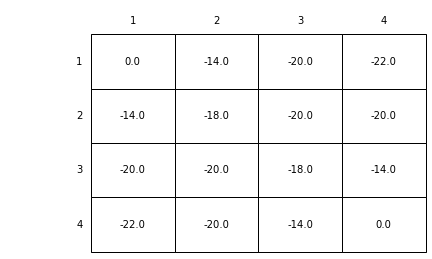

In [7]:
def figure_4_1():
    # While the author suggests using in-place iterative policy evaluation,
    # Figure 4.1 actually uses out-of-place version.
    _, asycn_iteration = compute_state_value(in_place=True)
    values, sync_iteration = compute_state_value(in_place=False)
    draw_image(np.round(values, decimals=2))
    print('In-place: {} iterations'.format(asycn_iteration))
    print('Synchronous: {} iterations'.format(sync_iteration))

    plt.show()
    plt.close()
figure_4_1()

## 4-2

C:\Users\MrHo\AppData\Local\Temp\ipykernel_3632\1621972839.py:112: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  policy = np.zeros(value.shape, dtype=np.int)


max value change 196.62783361783852
max value change 134.98823859766583
max value change 91.41415360228919
max value change 67.17097732555729
max value change 51.29055484635097
max value change 38.49091000659837
max value change 29.406139835126424
max value change 25.7210573245398
max value change 22.381602293031023
max value change 19.40385808254939
max value change 16.77577350573091
max value change 14.47251552455765
max value change 12.464101852186843
max value change 10.719367983418692
max value change 9.20806226246873
max value change 7.9019189666795455
max value change 6.775146571130392
max value change 5.8045764710083745
max value change 4.969618520007145
max value change 4.252112693842776
max value change 3.6361309524054946
max value change 3.107761240497666
max value change 2.654891834022692
max value change 2.26700589940549
max value change 1.9349911763441128
max value change 1.650966802154585
max value change 1.4081276418079938
max value change 1.2006055672075036
max value c

max value change 0.0021719229242762594
max value change 0.0013911772695109903
max value change 0.0008154469392138708
max value change 0.0004459807777266178
max value change 0.0002340408432246477
max value change 0.00012037610895276885
max value change 6.173777182993945e-05
policy stable True


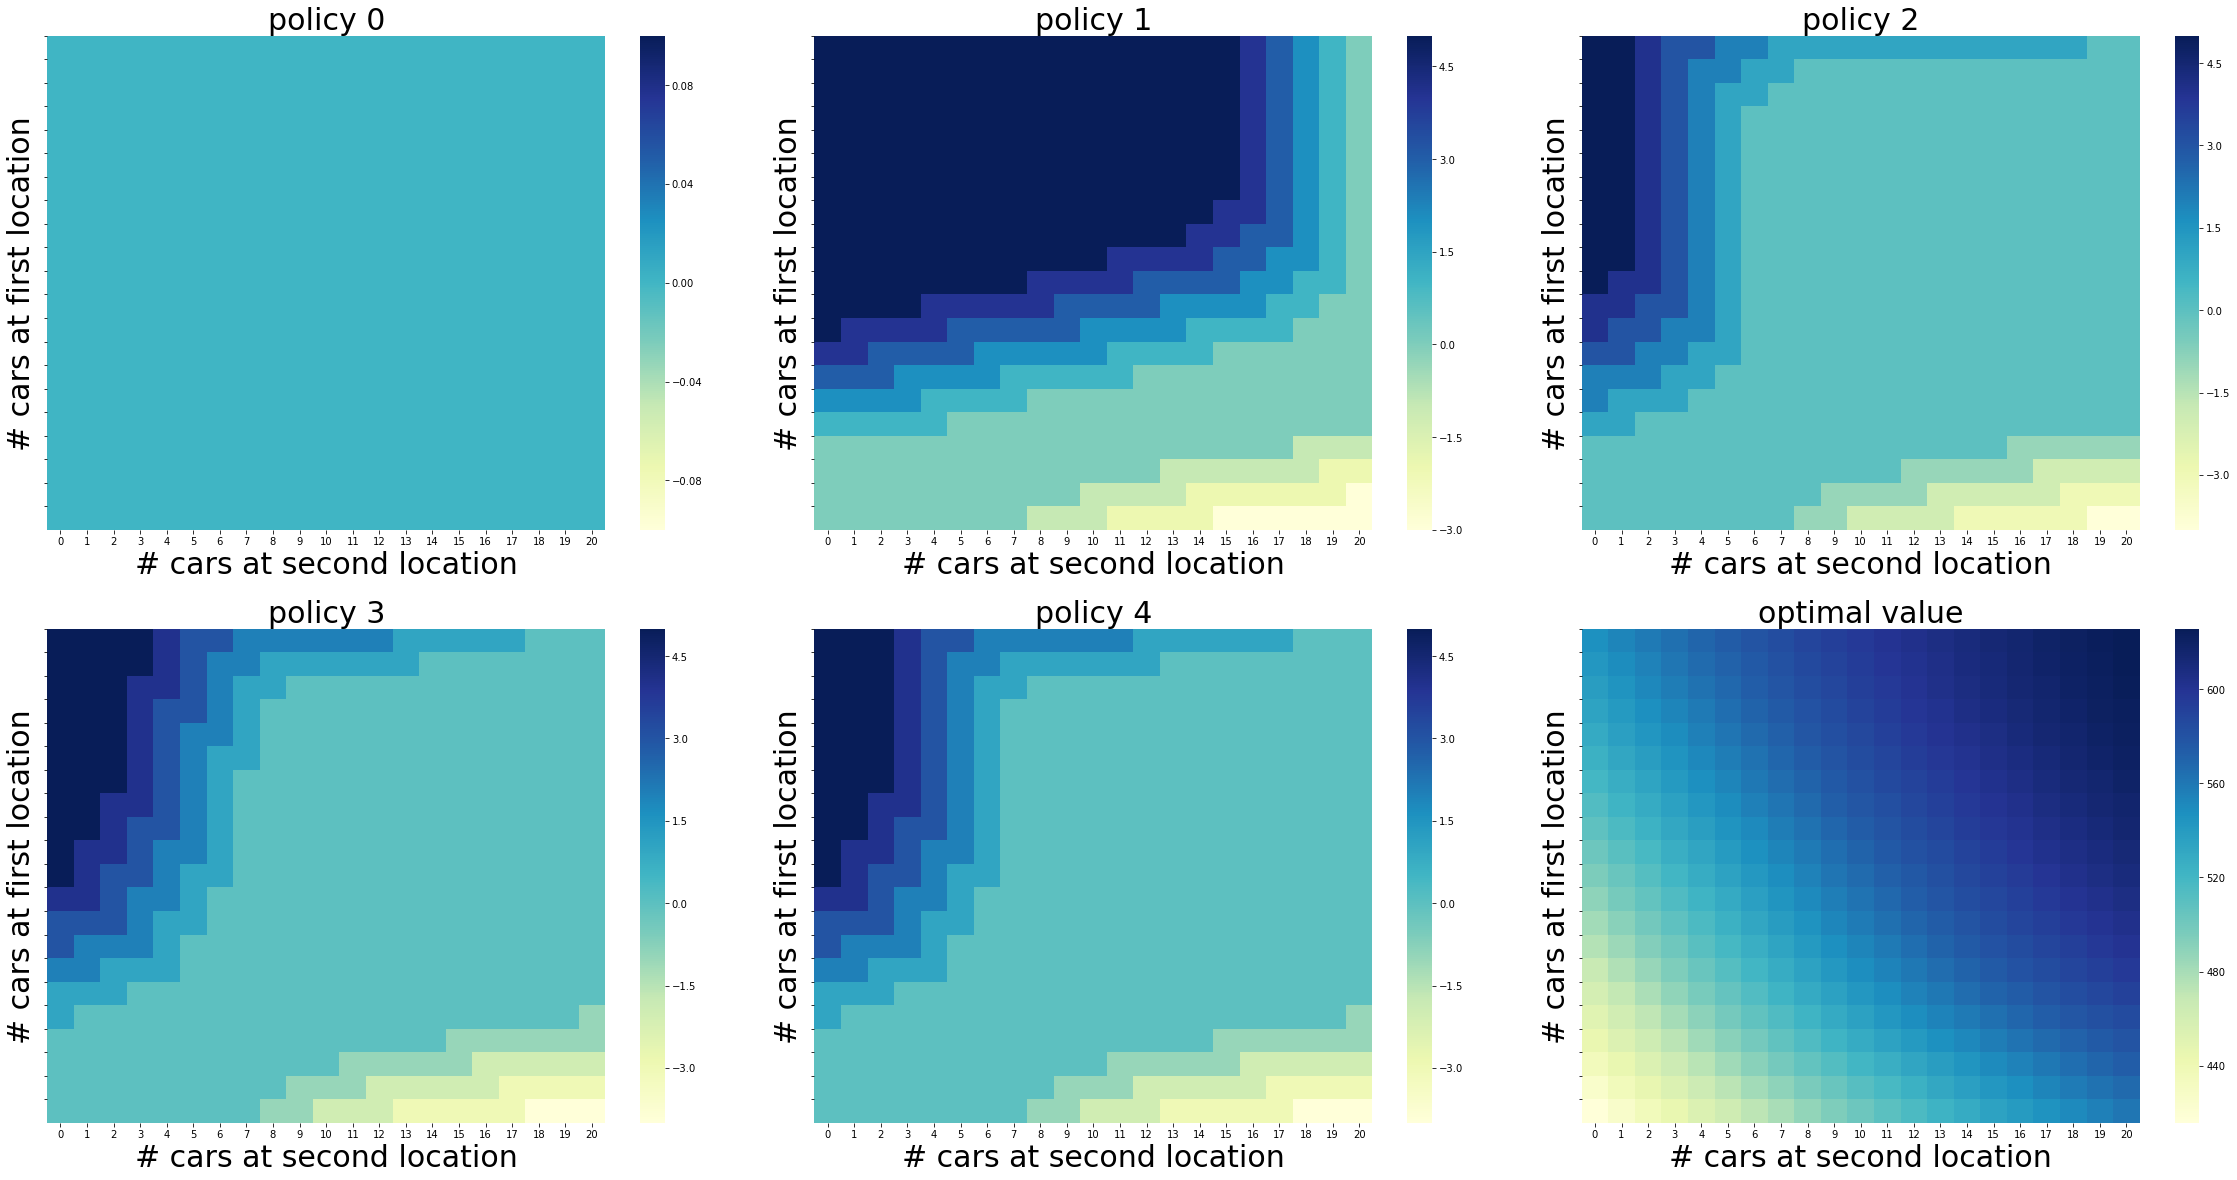

In [10]:
import seaborn as sns
from scipy.stats import poisson

# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()


def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]


def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns


def figure_4_2(constant_returned_cars=True):
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(value.shape, dtype=np.int)

    iterations = 0
    _, axes = plt.subplots(2, 3, figsize=(40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while True:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)

        # policy evaluation (in-place)
        while True:
            old_value = value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                    value[i, j] = new_state_value
            max_value_change = abs(old_value - value).max()
            print('max value change {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break

        # policy improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                    else:
                        action_returns.append(-np.inf)
                new_action = actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print('policy stable {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            break

        iterations += 1

    plt.show()
    plt.close()
figure_4_2()

## 4-3

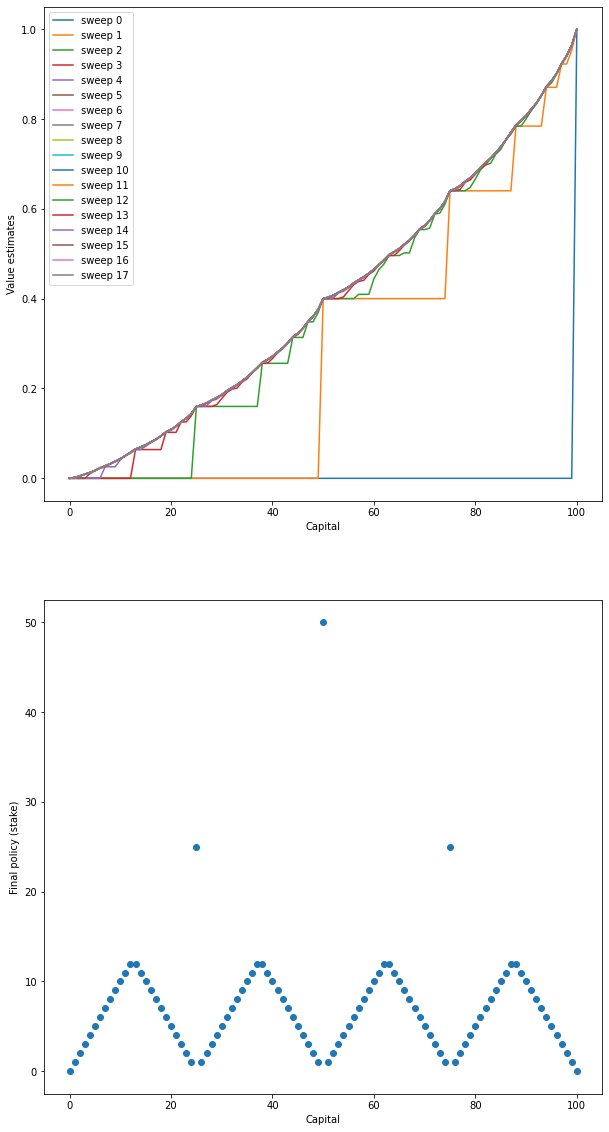

In [11]:
# goal
GOAL = 100

# all states, including state 0 and state 100
STATES = np.arange(GOAL + 1)

# probability of head
HEAD_PROB = 0.4


def figure_4_3():
    # state value
    state_value = np.zeros(GOAL + 1)
    state_value[GOAL] = 1.0

    sweeps_history = []

    # value iteration
    while True:
        old_state_value = state_value.copy()
        sweeps_history.append(old_state_value)

        for state in STATES[1:GOAL]:
            # get possilbe actions for current state
            actions = np.arange(min(state, GOAL - state) + 1)
            action_returns = []
            for action in actions:
                action_returns.append(
                    HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action])
            new_value = np.max(action_returns)
            state_value[state] = new_value
        delta = abs(state_value - old_state_value).max()
        if delta < 1e-9:
            sweeps_history.append(state_value)
            break

    # compute the optimal policy
    policy = np.zeros(GOAL + 1)
    for state in STATES[1:GOAL]:
        actions = np.arange(min(state, GOAL - state) + 1)
        action_returns = []
        for action in actions:
            action_returns.append(
                HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action])

        # round to resemble the figure in the book, see
        # https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/issues/83
        policy[state] = actions[np.argmax(np.round(action_returns[1:], 5)) + 1]

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    for sweep, state_value in enumerate(sweeps_history):
        plt.plot(state_value, label='sweep {}'.format(sweep))
    plt.xlabel('Capital')
    plt.ylabel('Value estimates')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.scatter(STATES, policy)
    plt.xlabel('Capital')
    plt.ylabel('Final policy (stake)')

    plt.show()
    plt.close()
    
figure_4_3()

## Exercise 4.5

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
import multiprocessing as mp
from functools import partial
import time
import itertools

############# PROBLEM SPECIFIC CONSTANTS #######################
MAX_CARS = 20
MAX_MOVE = 5
MOVE_COST = -2
ADDITIONAL_PARK_COST = -4

RENT_REWARD = 10
# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3
# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4
# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3
# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2
################################################################

poisson_cache = dict()


def poisson(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache.keys():
        poisson_cache[key] = math.exp(-lam) * math.pow(lam, n) / math.factorial(n)
    return poisson_cache[key]


class PolicyIteration:
    def __init__(self, truncate, parallel_processes, delta=1e-2, gamma=0.9, solve_4_5=False):
        self.TRUNCATE = truncate
        self.NR_PARALLEL_PROCESSES = parallel_processes
        self.actions = np.arange(-MAX_MOVE, MAX_MOVE + 1)
        self.inverse_actions = {el: ind[0] for ind, el in np.ndenumerate(self.actions)}
        self.values = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        self.policy = np.zeros(self.values.shape, dtype=np.int)
        self.delta = delta
        self.gamma = gamma
        self.solve_extension = solve_4_5

    def solve(self):
        iterations = 0
        total_start_time = time.time()
        while True:
            start_time = time.time()
            self.values = self.policy_evaluation(self.values, self.policy)
            elapsed_time = time.time() - start_time
            print(f'PE => Elapsed time {elapsed_time} seconds')
            start_time = time.time()

            policy_change, self.policy = self.policy_improvement(self.actions, self.values, self.policy)
            elapsed_time = time.time() - start_time
            print(f'PI => Elapsed time {elapsed_time} seconds')
            if policy_change == 0:
                break
            iterations += 1
        total_elapsed_time = time.time() - total_start_time
        print(f'Optimal policy is reached after {iterations} iterations in {total_elapsed_time} seconds')

    # out-place
    def policy_evaluation(self, values, policy):

        global MAX_CARS
        while True:
            new_values = np.copy(values)
            k = np.arange(MAX_CARS + 1)
            # cartesian product
            all_states = ((i, j) for i, j in itertools.product(k, k))

            results = []
            with mp.Pool(processes=self.NR_PARALLEL_PROCESSES) as p:
                cook = partial(self.expected_return_pe, policy, values)
                results = p.map(cook, all_states)

            for v, i, j in results:
                new_values[i, j] = v

            difference = np.abs(new_values - values).sum()
            print(f'Difference: {difference}')
            values = new_values
            if difference < self.delta:
                print(f'Values are converged!')
                return values

    def policy_improvement(self, actions, values, policy):
        new_policy = np.copy(policy)

        expected_action_returns = np.zeros((MAX_CARS + 1, MAX_CARS + 1, np.size(actions)))
        cooks = dict()
        with mp.Pool(processes=8) as p:
            for action in actions:
                k = np.arange(MAX_CARS + 1)
                all_states = ((i, j) for i, j in itertools.product(k, k))
                cooks[action] = partial(self.expected_return_pi, values, action)
                results = p.map(cooks[action], all_states)
                for v, i, j, a in results:
                    expected_action_returns[i, j, self.inverse_actions[a]] = v
        for i in range(expected_action_returns.shape[0]):
            for j in range(expected_action_returns.shape[1]):
                new_policy[i, j] = actions[np.argmax(expected_action_returns[i, j])]

        policy_change = (new_policy != policy).sum()
        print(f'Policy changed in {policy_change} states')
        return policy_change, new_policy

    # O(n^4) computation for all possible requests and returns
    def bellman(self, values, action, state):
        expected_return = 0
        if self.solve_extension:
            if action > 0:
                # Free shuttle to the second location
                expected_return += MOVE_COST * (action - 1)
            else:
                expected_return += MOVE_COST * abs(action)
        else:
            expected_return += MOVE_COST * abs(action)

        for req1 in range(0, self.TRUNCATE):
            for req2 in range(0, self.TRUNCATE):
                # moving cars
                num_of_cars_first_loc = int(min(state[0] - action, MAX_CARS))
                num_of_cars_second_loc = int(min(state[1] + action, MAX_CARS))

                # valid rental requests should be less than actual # of cars
                real_rental_first_loc = min(num_of_cars_first_loc, req1)
                real_rental_second_loc = min(num_of_cars_second_loc, req2)

                # get credits for renting
                reward = (real_rental_first_loc + real_rental_second_loc) * RENT_REWARD

                if self.solve_extension:
                    if num_of_cars_first_loc >= 10:
                        reward += ADDITIONAL_PARK_COST
                    if num_of_cars_second_loc >= 10:
                        reward += ADDITIONAL_PARK_COST

                num_of_cars_first_loc -= real_rental_first_loc
                num_of_cars_second_loc -= real_rental_second_loc

                # probability for current combination of rental requests
                prob = poisson(req1, RENTAL_REQUEST_FIRST_LOC) * \
                       poisson(req2, RENTAL_REQUEST_SECOND_LOC)
                for ret1 in range(0, self.TRUNCATE):
                    for ret2 in range(0, self.TRUNCATE):
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + ret1, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + ret2, MAX_CARS)
                        prob_ = poisson(ret1, RETURNS_FIRST_LOC) * \
                                poisson(ret2, RETURNS_SECOND_LOC) * prob
                        # Classic Bellman equation for state-value
                        # prob_ corresponds to p(s'|s,a) for each possible s' -> (num_of_cars_first_loc_,num_of_cars_second_loc_)
                        expected_return += prob_ * (
                                reward + self.gamma * values[num_of_cars_first_loc_, num_of_cars_second_loc_])
        return expected_return

    # Parallelization enforced different helper functions
    # Expected return calculator for Policy Evaluation
    def expected_return_pe(self, policy, values, state):

        action = policy[state[0], state[1]]
        expected_return = self.bellman(values, action, state)
        return expected_return, state[0], state[1]

    # Expected return calculator for Policy Improvement
    def expected_return_pi(self, values, action, state):

        if ((action >= 0 and state[0] >= action) or (action < 0 and state[1] >= abs(action))) == False:
            return -float('inf'), state[0], state[1], action
        expected_return = self.bellman(values, action, state)
        return expected_return, state[0], state[1], action

    def plot(self):
        print(self.policy)
        plt.figure()
        plt.xlim(0, MAX_CARS + 1)
        plt.ylim(0, MAX_CARS + 1)
        plt.table(cellText=np.flipud(self.policy), loc=(0, 0), cellLoc='center')
        plt.show()


if __name__ == '__main__':
    TRUNCATE = 9
    solver = PolicyIteration(TRUNCATE, parallel_processes=4, delta=1e-1, gamma=0.9, solve_4_5=True)
    solver.solve()
    solver.plot()

C:\Users\MrHo\AppData\Local\Temp\ipykernel_3632\157092055.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.policy = np.zeros(self.values.shape, dtype=np.int)
